# LJ Tutorial 

Environment setup
```
git clone git@github.com:jennyfothergill/msibi.git
cd msibi
conda env create -f environment.yml
conda activate msibi
pip install -e .
```

In [1]:
import itertools

import freud
import gsd
import gsd.hoomd
import hoomd
import hoomd.md
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np

from msibi import MSIBI, State, Pair, mie

Remove old runs: only the rdf targets, run_template scripts, and the start.hoomdxml remain.

In [2]:
%%bash
rm -rf state*/_* rdfs/pair* potentials/* f_fits.log state*/log.txt state*/err.txt state*/run.py state*/query.dcd

Create the trajectories at the three statepoints... takes about 40 minutes on 2.2 GHz Intel Core i7.

In [3]:
kTs = [0.5, 1.5, 2.0]
n = 12
n_particles = n**3

In [4]:
# This cell takes 40 minutes. Don't uncomment and rerun it unless you have a good reason.

#for i,kT in enumerate(kTs):
#    hoomd.context.initialize("")
#    system = hoomd.init.create_lattice(
#        unitcell = (hoomd.lattice.sc(a=1.58, type_name="A")), 
#        n = n,
#    )
#    
#    nl = hoomd.md.nlist.cell()
#    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
#    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
#    hoomd.md.integrate.mode_standard(dt=0.001)
#    _all = hoomd.group.all()
#    nvt = hoomd.md.integrate.nvt(group=_all, kT=kT, tau=1)
#    nvt.randomize_velocities(seed=23)
#    hoomd.analyze.log(
#        filename=f'state{i}/LJ_kT{kT}.log',
#        quantities=["time", "temperature", "potential_energy"],
#        period=100,
#        overwrite=True
#    )
#    hoomd.dump.gsd(f'state{i}/trajectory{kT}.gsd', period=5e3, group=_all, overwrite=True)
#    hoomd.run(1e6)

Check that the system is equilibrated.

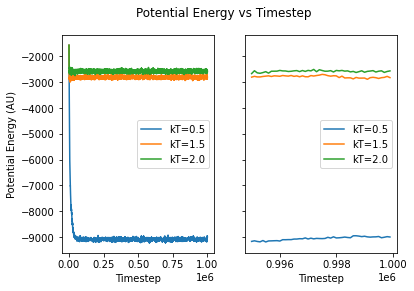

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle("Potential Energy vs Timestep")
for i, kT in enumerate(kTs):   
    log = np.loadtxt(f'state{i}/LJ_kT{kT}.log', skiprows=1)
    ax1.plot(log[:,0],log[:,3], label=f"kT={kT}")
    ax2.plot(log[-50:,0],log[-50:,3], label=f"kT={kT}")
    ax1.set_xlabel("Timestep")
    ax2.set_xlabel("Timestep")
    ax1.set_ylabel("Potential Energy (AU)")
    ax1.legend()
    ax2.legend()

Last 50 frames look equilibrated (TODO autocorrelation?) so we'll calculate the RDF of those.

NOTE: the next couple cells get very silly-- I got it in my head that the rdfs between freud and mdtraj were different and that was maybe what was causing my issue, so I felt the need to check that they were the same. Well, they _are_ the same and I still don't know what my issue is.

The error I am getting is 

```RuntimeError: Undefined values in tail of potential.This probably means you need better sampling at this state point.```

does this mean I need more points in my rdf or I need a smaller timestep in my md run or what???

I found out that my rdfs were 0 because the trajectory wasn't loaded. Working on that below in the cell with `opt.optimize`

In [113]:
class Traj(object):
    def __init__(self, gsdfile, start):
        self._have_unitcell = True
        with gsd.hoomd.open(gsdfile) as t:
            self.xyz = np.stack([frame.particles.position for frame in t[start:]])
            self.unitcell_vectors = t[start:]
            
    @property
    def xyz(self):
        return self._xyz
    
    @xyz.setter
    def xyz(self, xyz):
        self._xyz = xyz
        self.n_atoms = xyz.shape[1]
        
    @property
    def unitcell_vectors(self):
        return self._unitcell_vectors
    
    @unitcell_vectors.setter
    def unitcell_vectors(self, traj):
        try:
            self._unitcell_vectors = np.stack(
                [box_to_matrix(f.configuration.box) for f in traj]
            )
            self.unitcell_angles = np.ones(3)*90
            self.unitcell_volumes = np.array([box_to_volume(f.configuration.box) for f in traj])
        except AttributeError:
            self._have_unitcell = False

In [110]:
def box_to_matrix(box):
    lx,ly,lz,xy,xz,yz = box
    return np.array(
        [[lx, xy*ly, xz*lz],
         [ 0,    ly, yz*lz],
         [ 0,     0,    lz]]
    )

def box_to_volume(box):
    lx,ly,lz,xy,xz,yz = box
    x = np.array(
        [[lx, xy*ly, xz*lz],
         [ 0,    ly, yz*lz],
         [ 0,     0,    lz]]
    )
    return np.product(np.sqrt(np.sum(x**2, axis=0)))

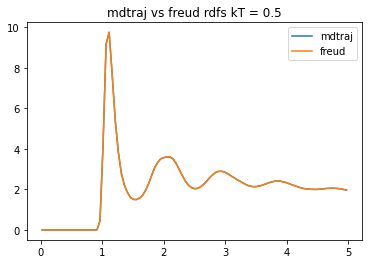

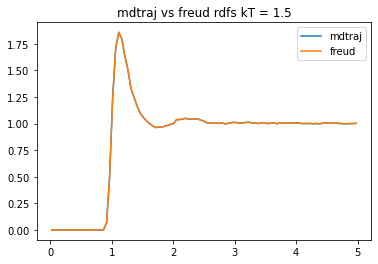

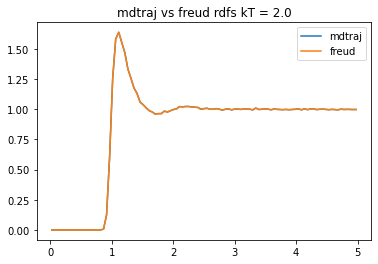

In [121]:
for i,kT in enumerate(kTs):
    gsdfile = f'state{i}/trajectory{kT}.gsd'
    traj = Traj(gsdfile,-50)
    rdf = md.compute_rdf(traj, indices, r_range=(0.0,5.0), n_bins=101)
    plt.title(f"mdtraj vs freud rdfs kT = {kT}")
    plt.plot(rdf[0],rdf[1], label="mdtraj")
    with gsd.hoomd.open(gsdfile) as t:
        rdf = freud.density.RDF(bins=101, r_max=5)
        for snap in t[-50:]:
            rdf.compute(system=snap, reset=False)
        data = np.stack((rdf.bin_centers, rdf.rdf)).T
        np.savetxt(f"rdfs/rdftarget{i}", data)
        plt.plot(rdf.bin_centers, rdf.rdf, label="freud")
        plt.legend()
        plt.show()

Set up global parameters:

- rdf_cutoff specifies how far out to calculate the rdf
- pot_cutoff specifies where to cut off the IBI calculation of the potential. The tail of the potential function (by default the last 5 points will be smoothed to zero using the [XPLOR smoothing function](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.pair). Small r values of the potential are also corrected using a linear correction by default. 
- smooth_rdfs if True, applies a Savitzky-Golay filter to the rdf array

TODO: this notebook should 
- prove that starting with the boltzmann inverse can iterate closer to "true" potential

- currently using mdtraj to load trajectory (dcd) and compute rdf--switch to freud and gsd?

- also why not show the smoothing etc?

In [4]:
rdf_cutoff = 5.0
opt = MSIBI(
    rdf_cutoff=rdf_cutoff, n_rdf_points=101, pot_cutoff=3.0, smooth_rdfs=True, verbose=True
)

Specify states

In [5]:
state0 = State(
    kT=0.5, 
    state_dir='./state0', 
    traj_file='trajectory0.5.gsd',
    name='state0', 
    backup_trajectory=True
)
state1 = State(
    kT=1.5, 
    state_dir='./state1', 
    traj_file='trajectory1.5.gsd',
    name='state1',
    backup_trajectory=True
)
state2 = State(
    kT=2.0, 
    state_dir='./state2', 
    traj_file='trajectory2.0.gsd',
    name='state2', 
    backup_trajectory=True
)
states = [state0, state1, state2]

Specify pairs

In [6]:
# all-all for n_particles atoms
# TODO use freud neighborlist?
# TODO write some logic to automate indices generation
indices = list(itertools.combinations(range(n_particles), 2))  

# 1-D array of potential values.
#TODO shouldn't this be boltzmann inverse?
initial_guess = mie(opt.pot_r, 1.0, 1.0)  # np array shape (61,)
rdf_targets = [
    np.loadtxt(f"rdfs/rdftarget{i}") for i in range(3)
]

pair0 = Pair('A', 'A', initial_guess)
alphas = [1.0, 1.0, 1.0]

/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: divide by zero encountered in true_divide
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)
/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: invalid value encountered in subtract
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)


Add targets to pair

In [7]:
for state, target, alpha in zip(states, rdf_targets, alphas):
    pair0.add_state(state, target, alpha, indices)
pairs = [pair0]  # optimize() expects a list of pairs

Implement MSIBI algorithm

Using HOOMD version 2.
-------- Iteration 0 --------
state0 traj before run_query <class 'NoneType'>
Launching 4 CPU threads...
    Running state state0 on CPU
    Running state state1 on CPU
    Launched HOOMD in ./state0
    Running state state2 on CPU
    Launched HOOMD in ./state1
    Launched HOOMD in ./state2
    Finished in ./state2.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state1.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state0.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
state0 traj after run_query <class 'mdtraj.core.trajectory.Trajectory'>
pair A-A, state state0, iteration 0: 0.969794
pair A-A, state state1, iteration 0: 0.991977
pair A-A, state state2, iteration 0: 0.992152


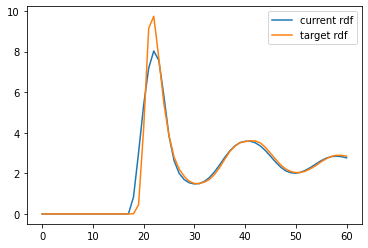

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


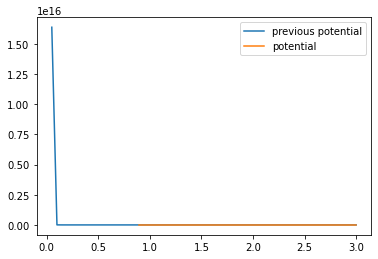

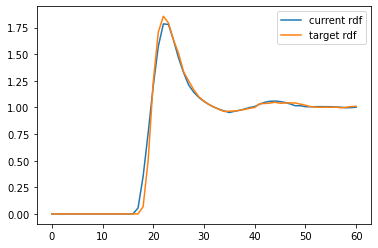

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


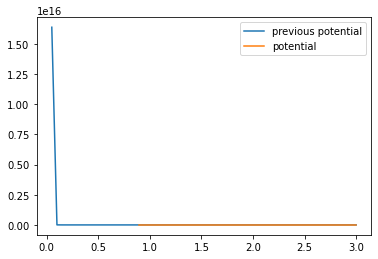

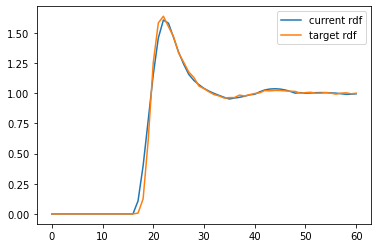

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


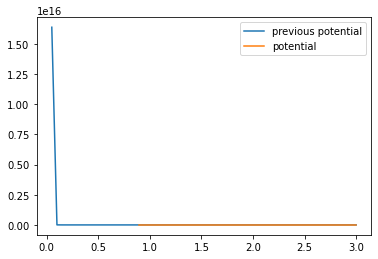

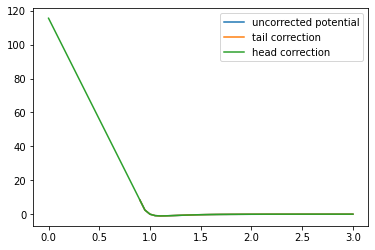

-------- Iteration 1 --------
state0 traj before run_query <class 'mdtraj.core.trajectory.Trajectory'>
Launching 4 CPU threads...
    Running state state1 on CPU    Running state state0 on CPU

    Running state state2 on CPU
    Launched HOOMD in ./state1    Launched HOOMD in ./state0

    Launched HOOMD in ./state2
    Finished in ./state1.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state2.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state0.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
state0 traj after run_query <class 'mdtraj.core.trajectory.Trajectory'>
pair A-A, state state0, iteration 1: 0.969794
pair A-A, state state1, iteration 1: 0.991977
pair A-A, state state2, iteration 1: 0.992152


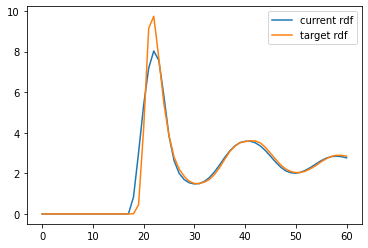

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


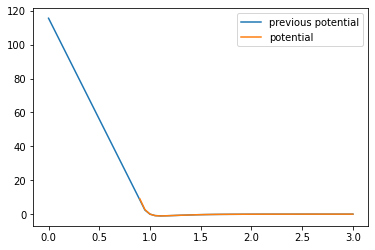

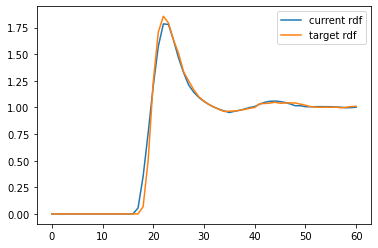

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


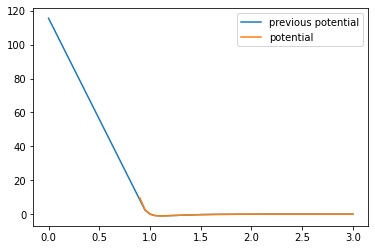

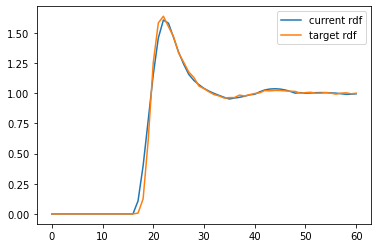

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


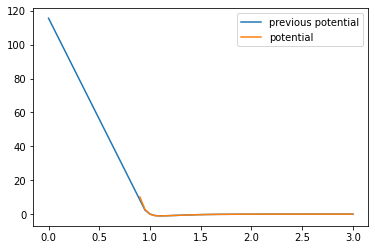

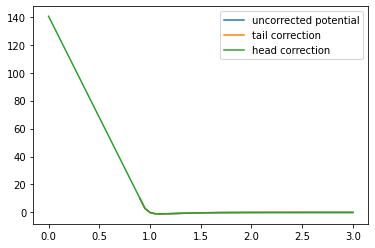

-------- Iteration 2 --------
state0 traj before run_query <class 'mdtraj.core.trajectory.Trajectory'>
Launching 4 CPU threads...
    Running state state2 on CPU    Running state state0 on CPU

    Running state state1 on CPU    Launched HOOMD in ./state2

    Launched HOOMD in ./state0
    Launched HOOMD in ./state1
    Finished in ./state2.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state1.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state0.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
state0 traj after run_query <class 'mdtraj.core.trajectory.Trajectory'>
pair A-A, state state0, iteration 2: 0.969794
pair A-A, state state1, iteration 2: 0.991977
pair A-A, state state2, iteration 2: 0.992152


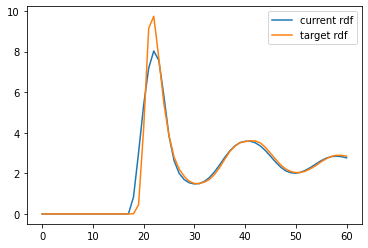

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


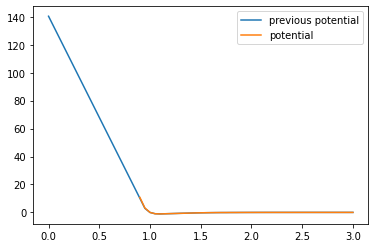

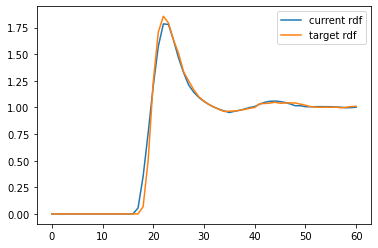

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


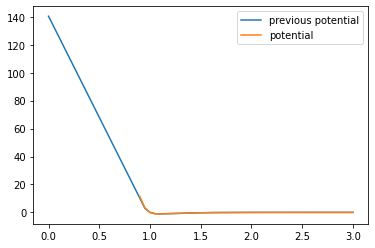

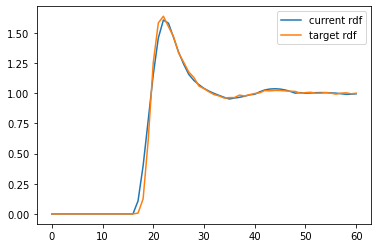

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


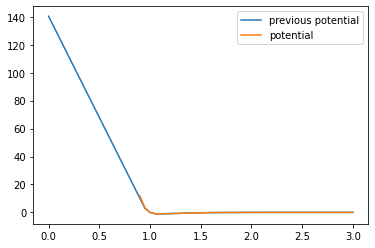

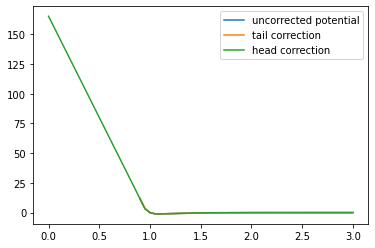

-------- Iteration 3 --------
state0 traj before run_query <class 'mdtraj.core.trajectory.Trajectory'>
Launching 4 CPU threads...
    Running state state0 on CPU    Running state state1 on CPU

    Launched HOOMD in ./state1
    Running state state2 on CPU
    Launched HOOMD in ./state0
    Launched HOOMD in ./state2
    Finished in ./state2.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state1.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state0.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
state0 traj after run_query <class 'mdtraj.core.trajectory.Trajectory'>
pair A-A, state state0, iteration 3: 0.969794
pair A-A, state state1, iteration 3: 0.991977
pair A-A, state state2, iteration 3: 0.992152


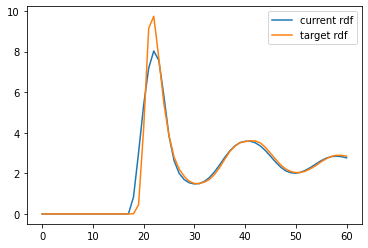

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


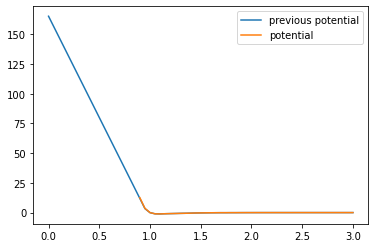

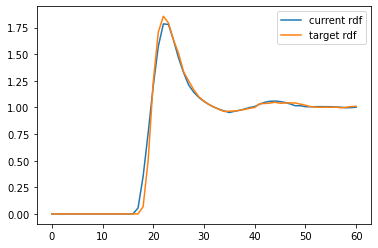

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


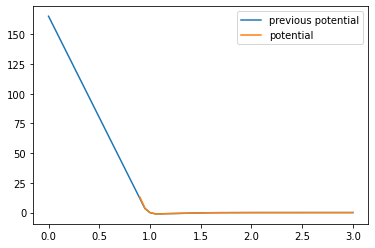

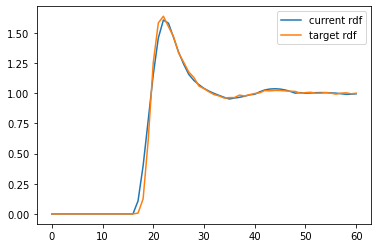

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


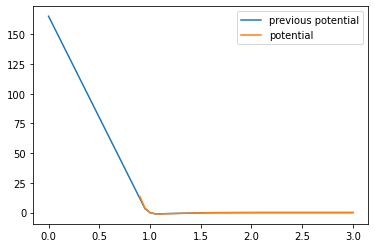

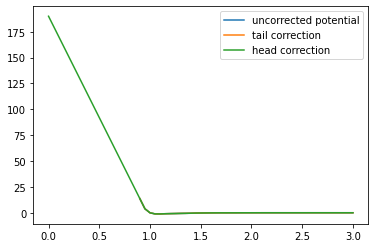

-------- Iteration 4 --------
state0 traj before run_query <class 'mdtraj.core.trajectory.Trajectory'>
Launching 4 CPU threads...
    Running state state0 on CPU    Running state state2 on CPU

    Running state state1 on CPU    Launched HOOMD in ./state0
    Launched HOOMD in ./state2

    Launched HOOMD in ./state1
    Finished in ./state2.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state1.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
    Finished in ./state0.
files closed
in workers.py _post_query
in state.py reload_query_trajectory
traj is  <class 'mdtraj.core.trajectory.Trajectory'>
state0 traj after run_query <class 'mdtraj.core.trajectory.Trajectory'>
pair A-A, state state0, iteration 4: 0.969794
pair A-A, state state1, iteration 4: 0.991977
pair A-A, state state2, iteration 4: 0.992152


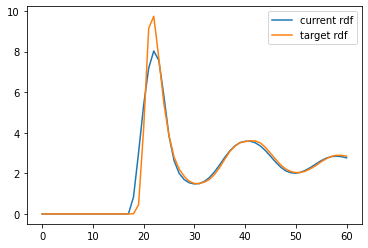

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


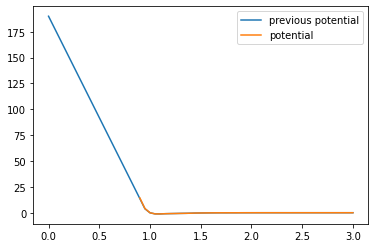

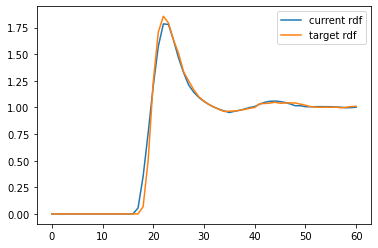

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


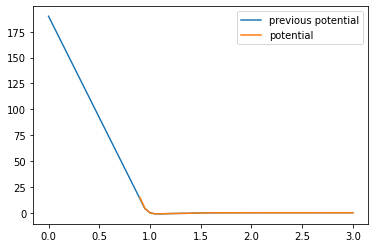

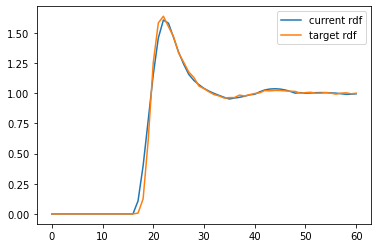

/Users/jenny/Projects/msibi/msibi/pair.py:211: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


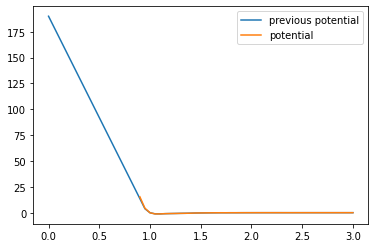

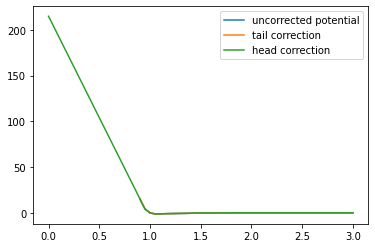

In [8]:
opt.optimize(states, pairs, n_iterations=5, engine='hoomd')

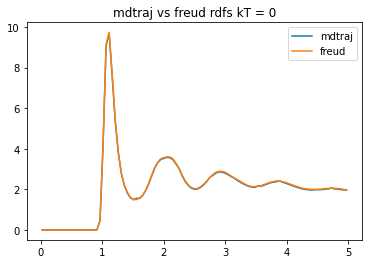

In [15]:
# is there any difference between mdtraj and freud rdfs? Nope
gsdfile = 'traj.gsd'
traj = state0.traj
traj.save_gsd(gsdfile)
rdf = md.compute_rdf(traj, indices, r_range=(0.0,5.0), n_bins=101)
plt.title(f"mdtraj vs freud rdfs kT = 0")
plt.plot(rdf[0],rdf[1], label="mdtraj")
with gsd.hoomd.open(gsdfile) as t:
    rdf = freud.density.RDF(bins=101, r_max=5)
    for snap in t[-50:]:
        rdf.compute(system=snap, reset=False)
    plt.plot(rdf.bin_centers, rdf.rdf, label="freud")
    plt.legend()
    plt.show()

In [12]:
help("traj.gsd"state0.traj.save_gsd)

Help on method save_gsd in module mdtraj.core.trajectory:

save_gsd(filename, force_overwrite=True) method of mdtraj.core.trajectory.Trajectory instance
    Save trajectory to HOOMD GSD format
    
    Parameters
    ----------
    filename : str
        filesystem path in which to save the trajectory
    force_overwrite : bool, default=True
        Overwrite anything that exists at filenames, if its already there



Plot results

In [2]:
import matplotlib.pyplot as plt

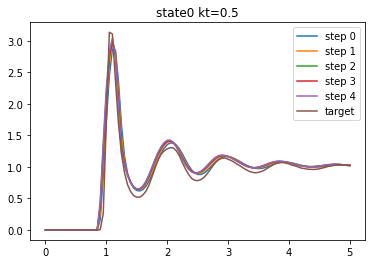

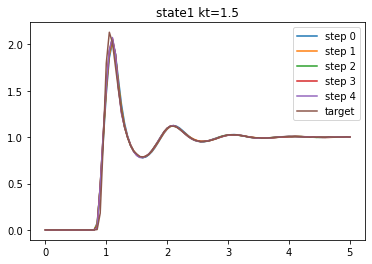

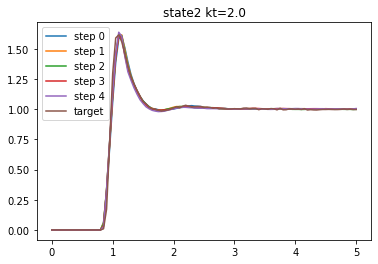

In [45]:
for state in states:
    plt.title(f'{state.name} kt={state.kT}')
    
    for step in range(0,opt.n_iterations):
        try:
            step_rdf = np.loadtxt(f'rdfs/pair_1-1-state_{state.name}-step{step}.txt')
            plt.plot(step_rdf[:,0],step_rdf[:,1], label=f'step {step}')
        except OSError:
            target = np.loadtxt(f'rdfs/rdf.target{state.name.strip("state")}.t1t1.txt')
            plt.plot(target[:,0], target[:,1], label='target')
            plt.legend()
            plt.show()
            break

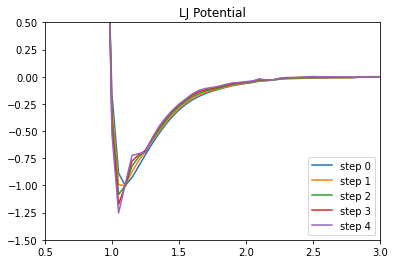

In [60]:
for step in range(0,opt.n_iterations):
    plt.ylim([-1.5,0.5])
    plt.xlim([0.5,3])
    plt.title("LJ Potential")
    try:
        step_pot = np.loadtxt(f'potentials/step{step}.pot.1-1.txt')
        plt.plot(step_pot[:,0],step_pot[:,1], label=f'step {step}')
    except OSError:
        plt.legend()
        plt.show()
        break

what potential was used to generate the targets?

In [65]:
from MDAnalysis.lib.formats.libdcd import DCDFile

In [70]:
with DCDFile('state0/query.dcd') as f:
    for frame in f:
        pass
print(frame.xyz)

[[-4.9447665  4.982726   2.500051 ]
 [-3.6839077 -4.326487   2.6648674]
 [ 3.8916466 -1.7114909 -4.8555593]
 ...
 [-0.8723145  2.4930065  2.9952328]
 [ 2.6854112 -1.4036062 -1.6191419]
 [-3.33116    3.018204   2.0835867]]


In [16]:
opt._recompute_rdfs(pair0,0)

pair A-A, state state0, iteration 0: 0.000000
pair A-A, state state1, iteration 0: 0.000000
pair A-A, state state2, iteration 0: 0.000000


In [20]:
opt.max_frames

1000.0

In [23]:
pair0.compute_current_rdf(
    state0,opt.rdf_r_range, n_bins=opt.rdf_n_bins, 
    smooth=opt.smooth_rdfs, max_frames=opt.max_frames
)

In [63]:
# from pair.py compute_current_rdf
# function inputs
state = state0
r_range = opt.rdf_r_range 
n_bins = opt.rdf_n_bins
smooth = opt.smooth_rdfs 
max_frames = opt.max_frames

# function body
pairs = pair0.states[state]["pair_indices"]                              
                  
g_r_all = None                                                          
first_frame = 0                                                         
max_frames = int(max_frames)                                                                                                            
r, g_r = md.compute_rdf(                                            
    state.traj,                             
    pairs,                                                          
    r_range=r_range,                                           
    n_bins=n_bins,                                                  
)   

In [67]:
len(state.traj[-50:])/state.traj.n_frames

0.25

In [57]:
r, g_r = md.compute_rdf(traj, indices, r_range=r_range/10, n_bins=n_bins)

In [58]:
g_r

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [40]:
#pair0.states[state0]["current_rdf"]